In [ ]:
## Cargamos paquetería
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose, STL


<a href="https://colab.research.google.com/github/milocortes/series_tiempo_mide/blob/main/src/mide_st_sesion_01_random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Componentes de las Series de Tiempo

Las series de tiempo pueden ser descompuestas en tres componentes:
* Tendencia : La tendencia representa los cambios lentos en una serie de tiempo. Es el componente responsable que explica que la serie aumente o disminuya gradualmente con el tiempo. El componente de tendencia a veces se denomina **nivel**.
* Componente estacional : El componente de estacionalidad representa el patrón estacional de la serie. Los ciclos ocurren de forma recurrente durante un período de tiempo fijo.
* Componente residual: Los residuales representan el comportamiento que no puede explicarse por los componentes de tendencia y estacionalidad. Corresponden a errores aleatorios, también denominados ruido blanco.

Visualizar estos componentes se conoce como **descomposición**. **Descomposición** se define como la tarea estadística que separa a una serie de tiempo en sus componentes.

### Ganancias trimestrales de Johnson & Johnson entre 1960-1980

Realicemos la descomposición de la serie de tiempo de ganancias trimestrales de Johnson & Johnson entre 1960-1980.

In [ ]:
# Cargamos la serie de tiempo
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')

# Creamos la columna year con tipo de dato DatetimeInde
df['year'] = pd.DatetimeIndex(df['date']).year

# Imprimimos los datos 
df

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961
...,...,...,...
79,1979-10-01,9.99,1979
80,1980-01-01,16.20,1980
81,1980-04-01,14.67,1980
82,1980-07-02,16.02,1980


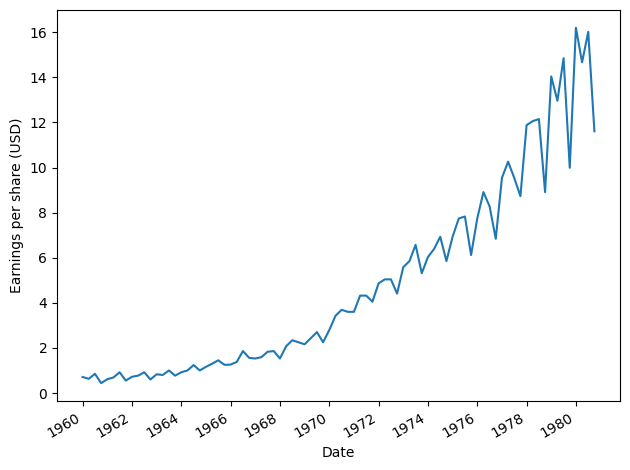

In [ ]:
## Graficamos la serie de tiempo
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
## Usamos la función STL del paquete statsmodels para hacer la descomposición de la serie de tiempo
## Puedes conocer la documentación del la función ejecutando STL?
advanced_decomposition = STL(df.data, period=4).fit()


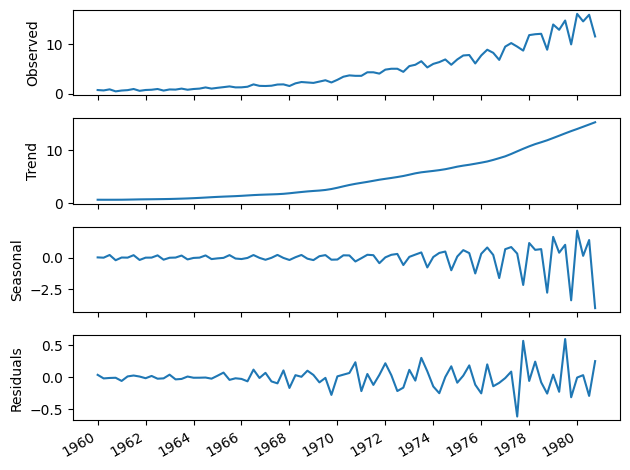

In [ ]:
## Graficamos la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## Pronósticos en Series de Tiempo

**Pronosticar** es predecir el futuro utilizando datos históricos y conocimiento de eventos futuros que podrían afectar nuestros pronósticos.

Marco Peixeiro propone el siguiente diagrama de cómo podría verse un proyecto de pronóstico completo en un entorno profesional:


![Tomado de *Time Series Forecasting in Python*](images/1_7.png)




### Developing a forecasting model
Con datos históricos a nuestra disposición, podemos desarrollar un **modelo de pronóstico**. Existen muchos modelos de pronóstico. Los que veremos en estas sesiones serán:
* AR
* MA
* ARMA
* ARIMA
  
Cualquiera que sea el modelo que se desarrolle, se utilizará parte de los datos de entrenamiento como conjunto de prueba (**training set**) para evaluar el rendimiento del modelo. El conjunto de prueba (**test set**) siempre serán los puntos de datos más recientes y debe ser representativo del horizonte de pronóstico.


El rendimiento del modelo se puede evaluar calculando una métrica de error o desempeño, como la error cuadrático medio (MSE).

Esta es una forma de evaluar qué tan alejadas están nuestras predicciones de los valores reales. 

Escogeremos el modelo con el MSE más bajo, esto es, el modelo con el mejor rendimiento de pronóstico.


### How time series forecasting is different from other regression tasks

* Time series have an order
* Time series sometimes do not have features

# Predicción ingenua del futuro
## Modelo de Referencia (baseline model)

Un **modelo de referencia** es una solución trivial a nuestro problema. 

A menudo utiliza heurísticas o estadísticas simples para generar predicciones. 

El modelo de referencia es la solución más simple que se pueda imaginar, no debería requerir ninguna capacitación y el costo de implementación debería ser muy bajo. Por ejemplo:

* Simplemente podemos calcular la media de los valores durante un período determinado y suponer que los valores futuros serán iguales a esa media.
* Otra posible base de referencia es pronosticar ingenuamente el último punto de datos registrado.
* O, si vemos un patrón cíclico en nuestros datos, simplemente podemos repetir ese patrón en el
futuro.

¿Qué tan bien pueden esos métodos simples predecir el futuro? Considerando el ejemplo de los datos de ganancias trimestrales de Johnson & Johnson podemos responder a esta pregunta pronosticando para el año 1980 y contrastando nuestros pronósticos con los datos observados en 1980. 

A esto se le llama pronóstico **fuera de muestra** (*out-of-sample*) porque estamos haciendo predicciones para un período que no se tuvo en cuenta cuando se desarrolló el modelo (test set).

De esa manera podemos medir el desempeño de nuestros modelos y ver cómo se comportarían cuando pronosticáramos más allá de los datos que tenemos, que en este caso son 1981 y posteriores.


### Pronóstico de la media histórica

In [ ]:
## Entrenaremos nuestro modelo con los datos trimestrales del periodo 1960-1979
## Probaremos el desempeño del modelo para los 4 trimestres de 1980
train = df[:-4]
test = df[-4:]

In [ ]:
## Calculamos la media histórica del periodo 1960-1979, el cual será nuestro primer modelo baseline
import numpy as np

historical_mean = np.mean(train['data'])
historical_mean

np.float64(4.308499987499999)

In [ ]:
## Ahora pronosticaremos ingenuamente este valor para cada trimestre de 1980 al crear
## una columna 'pred_mean' en el dataframe que toma el valor de la media histórica como pronóstico
test.loc[:, 'pred_mean'] = historical_mean
test

/tmp/ipykernel_2891847/1731245392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = historical_mean


,date,data,year,pred_mean
80,1980-01-01,16.20,1980,4.3085
81,1980-04-01,14.67,1980,4.3085
82,1980-07-02,16.02,1980,4.3085
83,1980-10-01,11.61,1980,4.3085


#### Cálculo del performance del modelo

Ahora debemos definir y calcular una métrica de error para evaluar el desempeño de nuestros pronósticos en el conjunto de prueba.


En este caso, usaremos el error porcentual absoluto medio (*mean absolute percentage error* - MAPE). 

Es una medida de precisión de predicción para métodos de pronóstico que es fácil de interpretar e independiente de la escala de nuestros datos. 

Esto significa que ya sea que estemos trabajando con valores de dos dígitos o de seis dígitos, el MAPE siempre se expresará como
un porcentaje.

Por lo tanto, el MAPE calcula el porcentaje de cuánto se desvían los valores pronosticados de los valores observados o reales en promedio.

La fórmula de MAPE es la siguiente:

$$
\begin{equation}
    \text{MAPE} = \dfrac{1}{n} \sum_{i=1}^n \Bigg|  \dfrac{A_i - F_i}{A_i}  \Bigg|
\end{equation}
$$

Donde $A_i$ es el valor actual en el tiempo $i$ y $F_i$ es el valor de pronóstico en el tiempo $i$. 

In [ ]:
## Definimos la función mape que calcula el MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Calculamos el MAPE de nuestro baseline:

In [ ]:
mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean

np.float64(70.00752579965119)

Al ejecutar la función obtenemos un MAPE de 70%. Esto significa que nuestro baseline se desvía en promedio 70% de los valores observados trimestrales para el pronóstico de 1980.

Visualizemos nuestro pronóstico para entender mejor este resultado:

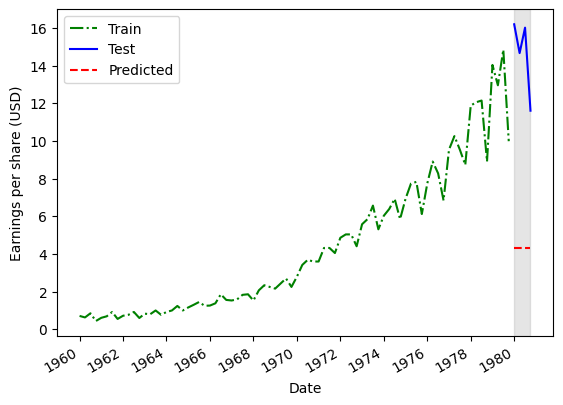

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,
1974, 1976, 1978, 1980])

fig.autofmt_xdate()



Por qué es malo nuestro pronóstico? La tendencia no es constante. Es una serie no estacionaria.

### Pronóstico de la media del último año

La lección aprendida de la línea del modelo baseline anterior es que los valores anteriores no parecen predecir valores futuros a largo plazo debido al componente de tendencia positiva en nuestro conjunto de datos. 

Los valores anteriores parecen demasiado pequeños para ser representativos del nuevo nivel que alcanza la EPS hacia finales de 1979 y en adelante hasta 1980.

¿Qué pasa si utilizamos la media del último año en nuestro conjunto de entrenamiento para pronosticar el año siguiente? Esto significa que calcularíamos el EPS promedio en 1979 y lo pronosticaríamos para cada trimestre de 1980.


In [ ]:
## Calculamos el promedio de los últimos 4 trimestres de nuestro conjunto de entrenamiento
last_year_mean = np.mean(train.data[-4:])
test.loc[:, 'pred__last_yr_mean'] = last_year_mean
test

/tmp/ipykernel_2891847/75427679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred__last_yr_mean'] = last_year_mean


,date,data,year,pred_mean,pred__last_yr_mean
80,1980-01-01,16.20,1980,4.3085,12.96
81,1980-04-01,14.67,1980,4.3085,12.96
82,1980-07-02,16.02,1980,4.3085,12.96
83,1980-10-01,11.61,1980,4.3085,12.96


In [ ]:
## Evaluamos el performance de nuestro nuevo baseline
mape_last_year_mean = mape(test['data'], test['pred__last_yr_mean'])
mape_last_year_mean

np.float64(15.5963680725103)

Obtenemos un MAPE de 15.6%. Este nuevo modelo base supone una clara mejora respecto al anterior, aunque su implementación es igual de sencilla, ya que disminuimos el MAP de 70% a 15.6%. Esto significa que nuestros pronósticos, en promedio, se desvían de los valores observados en un 15.6%.


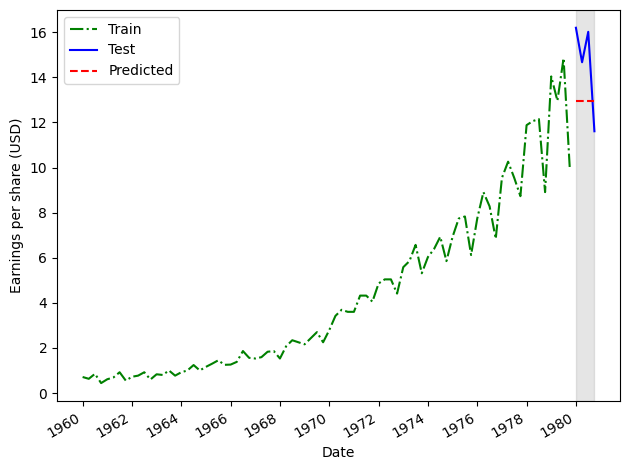

In [ ]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

Queremos obtener un MAP lo más cercano posible al 0%, ya que eso se traduciría en predicciones más cercanas a los valores reales en nuestro horizonte de pronóstico.

Podemos aprender de modelo baseline que los valores futuros probablemente dependan de valores pasados ​​que no están muy atrás en la historia. Es decir, la **autocorrelación** tiene un efecto importante en la serie.


### Pronóstico ingenuo de la estacionalidad

Hasta ahora en los dos modelos baseline exploraos se ha considerado el componente de tendencia y hemos excluido al componente estacional.

Al observar la descomposición de la serie de tiempo, identificamos patrones cíclicos claros en los datos, y esa es una información que podríamos utilizar para construir una última línea de base que incorpore el componente estacional.

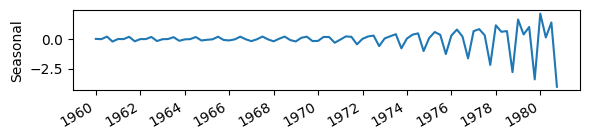

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1.5))

ax.plot(advanced_decomposition.seasonal)
ax.set_ylabel('Seasonal')
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


Nuestro modelo baseline estacional ingenuo toma el último ciclo observado y lo repite en el futuro. Es decir, supone que los valores observados en los 4 trimestres de 1979 se repetirán en 1980.

In [ ]:
## Repetimos los valores del ciclo de 1979 al año 1980
test.loc[:, 'pred_last_season'] = train['data'][-4:].values
test

/tmp/ipykernel_2891847/891504097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_season'] = train['data'][-4:].values


,date,data,year,pred_mean,pred__last_yr_mean,pred_last_season
80,1980-01-01,16.20,1980,4.3085,12.96,14.04
81,1980-04-01,14.67,1980,4.3085,12.96,12.96
82,1980-07-02,16.02,1980,4.3085,12.96,14.85
83,1980-10-01,11.61,1980,4.3085,12.96,9.99


In [ ]:
## Calculamos el mape
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

np.float64(11.561658552433654)

Obtenemos un MAPE de 11.56% que es el más bajo de los MAPEs calculados por los modelos baseline.

Esto significa que la estacionalidad tiene un impacto significativo en los valores futuros, ya que repetir la última temporada en el futuro produce pronósticos bastante precisos. 

Intuitivamente, esto tiene sentido, porque podemos observar claramente un patrón cíclico que se repite cada año.

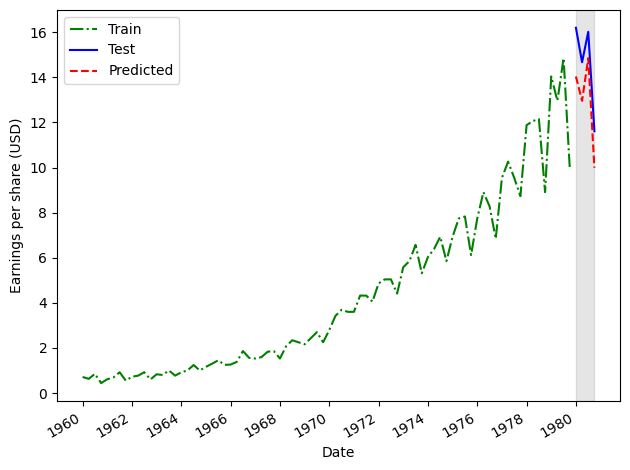

In [ ]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

Comparemos el desempeño de los modelos baseline construidos:

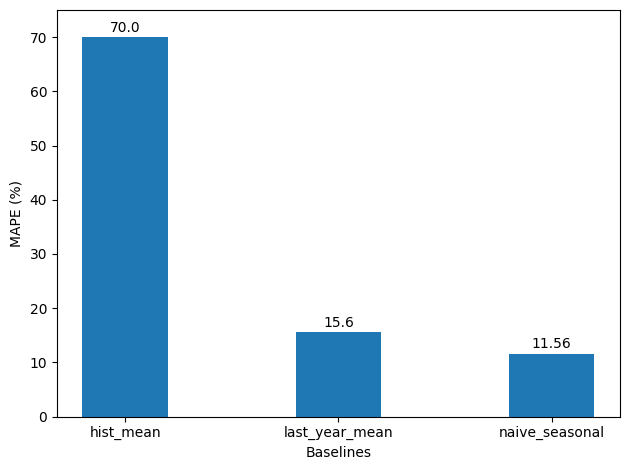

In [ ]:
fig, ax = plt.subplots()

x = ['hist_mean', 'last_year_mean', 'naive_seasonal']
y = [70.00, 15.60, 11.56]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 75)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')

plt.tight_layout()
